In [ ]:
#!pip3 install arviz
#!pip3 install pymc3==3.11.2 # esta versión sí tiene el método sample_smc

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks') #cambiar ruta segun donde este el archivo 'cuentitas.py' - es probable que deba dar permiso a drive desde el panel izquierdo
import cuentitas

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT

import pymc3 as pm
from google.colab import files
sns.set() #seaborn como default

In [ ]:
def S0VV_Fran_completo(k0,thi,phi,th,phs,ep1,ep2,d,s1,l1,s2,l2):
    
    k1 = k0*(sin(th)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(th)*sin(phs)-sin(thi)*sin(phi))
    
    return 4*np.pi*k0**2*cos(th)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,th,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,th,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,th,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,th,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))

In [ ]:
### paqueton
# Elegimos el orden
n = 25

# Precalculamos nodos y pesos (única vez para todas las integrales
beta = np.zeros(n,dtype=float)
for k in range(1,n+1):
    beta[k-1] = 0.5/sqrt(1-(2*(k))**(-2))

m = n+1
T_low = np.zeros((m,m))
T_up = np.zeros((m,m))
T = np.zeros((m,m))
    
# defino T_low
for i in range(0,m):
    for j in range(0,m):
        if i==j+1:
            T_low[i,j]=beta[i-1]

    # defino T_up
for i in range(0,m):
    for j in range(0,m):
        if j==i+1:
            T_up[i,j]=beta[i]


T = T_low + T_up        
d_,V = np.linalg.eig(T)
D = np.zeros((m,m))

for i in range(0,m):
    for j in range(0,m):
        if i==j:
            D[i,j]=d_[i]

W = (2*V[0,:]**2)
Wt = np.kron(W,W)

X,Y = np.meshgrid(d_,d_)
### fin paqueton

In [ ]:
def toFit(ep1,ep2,d,s1,l1,s2,l2,angulo):
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))

    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
        
    ### emi
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_Fran_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()

    emi = 1 - (I_gauss/(4*np.pi))

    a = TT.zeros(4)
    aa = TT.set_subtensor(a[0], s0s[0])
    aaa = TT.set_subtensor(aa[1], s0s[1])
    aaaa = TT.set_subtensor(aaa[2], s0s[2])
    aaaaa = TT.set_subtensor(aaaa[3], emi)
 
    return aaaaa

In [ ]:
def medicion(zona):     #angulo - observacion - nombre
    if zona == 'VP1':
        out = [np.asarray([20.44, 18.79, 17.36]),np.asarray([-6.13, -5.71, -5.66, 0.927]),'VP1']
    elif zona == 'VP2':
        out = [np.asarray([18.63, 17.19, 11.25]),np.asarray([-6.65, -6.17, -5.93, 0.937]),'VP2']
    elif zona == 'HU0':
        out = [np.asarray([24.59, 15.76, 20.69]),np.asarray([-4.07, -3.27, -3.59, 0.917]),'HU0']
    elif zona == 'HU1':
        out = [np.asarray([22.46, 15.33, 15.57]),np.asarray([-3.64, -3.12, -2.90, 0.921]),'HU1']
    elif zona == 'HU2':
        out = [np.asarray([18.86, 21.10, 12.98]),np.asarray([-4.08, -9.34, -3.55, 0.914]),'HU2']
    elif zona == 'DU1':
        out = [np.asarray([17.20, 20.10, 12.98]),np.asarray([-9.02, -9.55, -8.09, 0.943]),'DU1']
    elif zona == 'DU2':
        out = [np.asarray([23.84, 11.21, 12.64]),np.asarray([-11.96, -6.82, -7.99, 0.954]),'DU2']
    elif zona == 'DP1':
        out = [np.asarray([19.64, 17.76, 14.06]),np.asarray([-7.79, -8.34, -7.44, 0.947]),'DP1']
    elif zona == 'DP2':
        out = [np.asarray([24.21, 13.78, 16.76]),np.asarray([-11.25, -8.29, -8.62, 0.937]),'DP2']
    else:
      print('\n Inputs: VP1, VP2, HU0, HU1, HU2, DU1, DU2, DP1, DP2 \n')
    
    return out

In [ ]:
sigmas = np.asarray([0.5, 0.5, 0.5, 0.05])

In [ ]:
def modelo(sector, samples, sigmas):

    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi

    ranges = {}
#    ranges['ep1'] = 1.4, 8
    ranges['ep1'] = 1.4, 3 #para HU2, primera iteracion
    ranges['ep2'] = 1.4, 8
    ranges['d'] = 0.001, 0.1
    ranges['s1'] = 0.0004, 0.004
    ranges['l1'] = 0.005, 0.03
    ranges['s2'] = 0.0004, 0.004
    ranges['l2'] = 0.005, 0.03

    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        l1 = pm.Uniform('l1', ranges['l1'][0], ranges['l1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
        l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])

    def f(ep1 = ep1, 
               ep2 = ep2, 
               d = d, 
               s1 = s1, 
               l1 = l1,
               s2 = s2, 
               l2 = l2):
        return toFit(ep1,ep2,d,s1,l1,s2,l2,sector[0])

    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        #trace = pm.sample_smc(samples, parallel=False)  #porque no corre las cadenas en parelelo? Es mas rapido False
        trace = pm.sample_smc(samples, cores=2, parallel=True) #probar con 4 
    print('Ploteando...')

    plotear = np.stack((trace['ep1'], trace['ep2'], trace['d'], trace['s1'], trace['l1'], trace['s2'], trace['l2'])).T 
    dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','l1','s2','l2'])

    g = sns.PairGrid(dfplotear)
    g.fig.suptitle(sector[2], y=1.01, fontsize = 'xx-large')
    g.map_upper(sns.histplot)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot, kde=True)
    g.savefig('prueba.png')
    #files.download('prueba.png') #descarga la imagen
    return trace


Initializing SMC sampler...
Sampling 2 chains in 2 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As 

Ploteando...


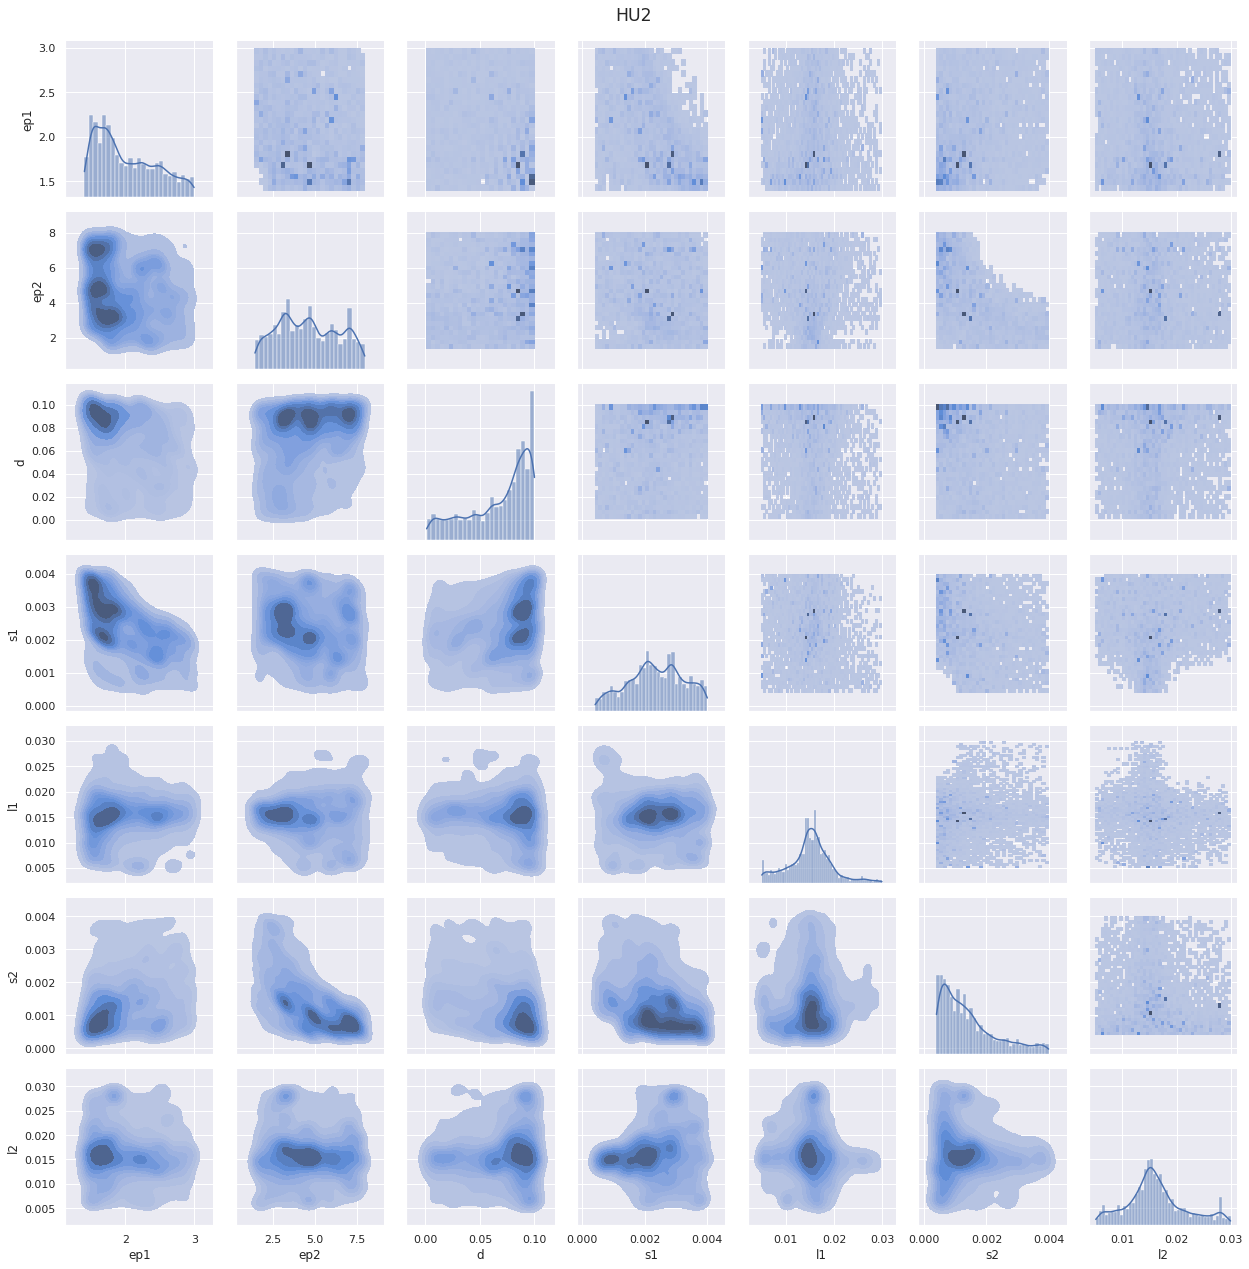

In [ ]:
traza = modelo(medicion('HU2'),5000,sigmas)



---
# Pruebas a segundo orden


In [ ]:
thInc = medicion('HU2')[0]
thSc = thInc
phInc = np.pi
phSc = phInc + np.pi

landa = 0.025
k0 = 2*np.pi/landa

l2 = 0.015
s2 = 0.00085
l1 = 0.015
s1 = 0.0014
d = 0.009
ep2 = 6.25

ep1 = np.linspace(1.4, 4.7, 1000)

import matplotlib.pyplot as plt




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'HU2')

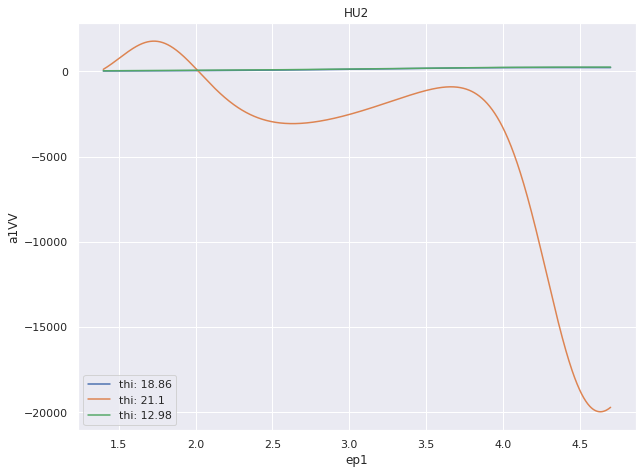

In [ ]:
plt.figure(figsize=[10.0,7.5])
for i in range(len(thInc)):
  plt.plot(ep1, cuentitas.a1VVF1(k0,thInc[i],phInc,thSc[i],phSc,ep1,ep2,d),label='thi: '+str(thInc[i]))


plt.legend()
plt.xlabel('ep1')
plt.ylabel('a1VV')
plt.title('HU2')

